<a href="https://colab.research.google.com/github/Yashu2699/Deep_learning/blob/main/Semantic_seg/Unet_Segmentation_models_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models

In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
height = 128
width = 128
n_classes = 4

train_images = []
for path in glob.glob('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/image_datasets/images/'):
  for img_path in glob.glob(os.path.join(path, '*.tif')):
    img = cv2.imread(img_path, 1)
    train_images.append(img)

train_images = np.array(train_images)

train_masks = []
for path in glob.glob('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/image_datasets/masks_final/'):
  for img_path in glob.glob(os.path.join(path, '*.tif')):
    mask = cv2.imread(img_path, 0)
    train_masks.append(mask)

train_masks = np.array(train_masks)

In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1).ravel()
train_masks_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_ = train_masks_encoded.reshape(n, h, w)

In [5]:
train_masks_input = np.expand_dims(train_masks_, axis=3)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

In [7]:
from tensorflow.keras.utils import to_categorical 

y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.FocalLoss()
total_loss = dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
from sklearn.utils.extmath import softmax
model1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(model1)

X_train_resnet = preprocess_input1(X_train)
X_test_resnet = preprocess_input1(X_test)

resnet_model = sm.Unet(model1, encoder_weights='imagenet', activation='softmax', classes=n_classes)

resnet_model.compile(optimizer, total_loss, metrics=metrics)
resnet_model.summary()

In [ ]:
history_resnet = resnet_model.fit(X_train_resnet, y_train_cat,
                                  batch_size=8, epochs=50,
                                  verbose=1,
                                  validation_data=(X_test_resnet, y_test_cat))

resnet_model.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/h5_files/resnet_sm_backbone.hdf5')

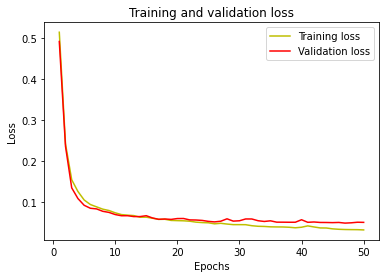

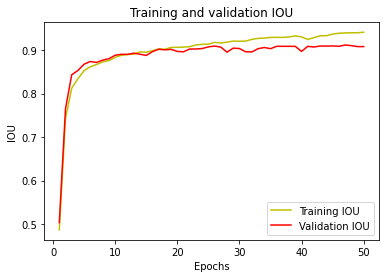

In [12]:
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_resnet.history['iou_score']
val_acc = history_resnet.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [19]:
y_pred = resnet_model.evaluate(X_test_resnet, y_test_cat)
print('iou_score on test_set is {}' .format(y_pred[1]))

5/5 [==============================] - 1s 140ms/step - loss: 0.0479 - iou_score: 0.9140 - f1-score: 0.9537
iou_score on test_set is 0.9140283465385437
